<a href="https://colab.research.google.com/github/LiterallyTheOne/deep_learning_class/blob/main/notebooks/session_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session_8: Generative AI, LLM, Gemini, Multi-modal prompting

# Generative AI

Genernerative AI is a field in deep learning that focuceses on generating new data (text, image, audio, ...).
For example:
* ChatGPT: Text generation
* DALL-E: Image generation
* Wavenet: Audio generation

## Transformers

## LLM

## Gemini

Gemini is a multi-modal model presented by `Google`.
It can take a prompt, image, audio and even a viedo
and generate a response in multiple formats (text, image, audio, video).

We are going to use that to classify one batch of our images.

## Create a Gemini API token

To create an API token, we can use this link: [AI Studio](https://aistudio.google.com/app/apikey)

## Setup

In [1]:
try:
    import google.colab

    %pip install -U -q "google-generativeai>=0.8.3"
    IN_COLAB = True
except:
    IN_COLAB = False


## Imports

In [2]:
import google.generativeai as genai
from google.api_core import retry
import kagglehub

from pathlib import Path

import keras
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image

import enum

In [3]:
if IN_COLAB:
    from google.colab import userdata

    api_key = userdata.get("GOOGLE_API_KEY")
else:
    api_key = Path("../api_keys/google_api_key").open().read()

genai.configure(api_key=api_key)

## Choose a model

In [4]:
for model in genai.list_models():
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-exp-1206
models/gemini-exp-1121
models/gemini-exp-1114
models/learnlm-1.5-pro-experimental
models/embedding-001
models/text-embedding-004
models/aqa


In [5]:
retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

model = genai.GenerativeModel("gemini-1.5-flash-latest")

## Get data

In [6]:
import kagglehub

path = Path(kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification"))

data_path = path / "tom_and_jerry/tom_and_jerry"

100%|██████████| 435M/435M [00:05<00:00, 89.6MB/s]

Extracting files...


## Load data

In [7]:
BATCHSIZE = 12

all_train_data, test_data = keras.utils.image_dataset_from_directory(
    data_path,
    seed=10,
    validation_split=0.2,
    subset="both",
    batch_size=BATCHSIZE,
    image_size=(80, 190),
    shuffle=True,
)

one_batch_of_test_data = test_data.take(1)

images, labels = next(iter(one_batch_of_test_data))

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Using 1095 files for validation.


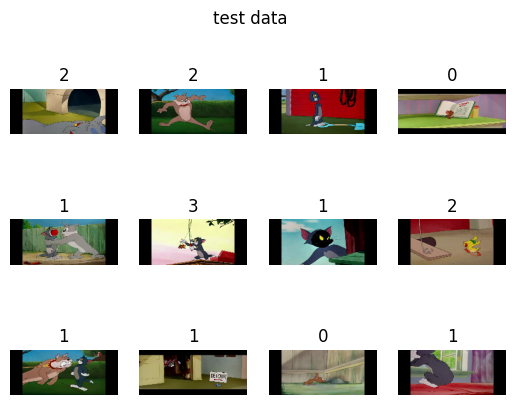

In [8]:
fig, axes = plt.subplots(3, 4)

fig.suptitle("test data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    axes_ravel[i].set_title(f"{label}")

## Multi-modal promptmpting

In [9]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "What is this? Please describe it in detail.",
    Image.fromarray(images[1].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's Spike, the bulldog from the *Tom and Jerry* cartoons.

The image shows Spike in a dynamic pose, mid-stride, seemingly in pursuit of something (likely Tom or Jerry, though neither are visible).  Here's a breakdown of the details:

* **Pose and Movement:** Spike is depicted in a powerful, low-to-the-ground running stance.  His legs are spread wide, suggesting speed and aggression. His arms are bent, one raised higher than the other, reinforcing the sense of motion and force.  The overall impression is one of intense energy and imminent action.

* **Appearance:** Spike is his typical design: a large, muscular bulldog with light brown fur. His expression is fierce, with narrowed eyes and a slightly bared mouth hinting at a growl or snarl.  His build is stocky and powerful, indicative of his strength and intimidating presence in the cartoons.

* **Setting:** The background features a green hedge, common in *Tom and Jerry* settings, and a portion of a tree trunk and branches.  The gro

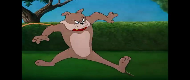

In [10]:
Image.fromarray(images[1].numpy().astype("uint8"))

## Classify an image

In [11]:
prompt = [
    """This image blongs to a cartoon called Tom and Jerry, classify this image as TOM, JERRY, NONE or BOTH.
TOM: when only tom is in the image
Jerry: when only jerry is in the image
NONE: when neither tom nor jerry is in the image
BOTH: when both tom and jerry are in the image
Sentiment: """,
    Image.fromarray(images[1].numpy().astype("uint8")),
]

response = model.generate_content(prompt)
print(response.text)

NONE

The image shows Spike, the bulldog, who is a recurring character in Tom and Jerry, but neither Tom nor Jerry are present.


## Use Enum

In [ ]:
class Sentiment(enum.Enum):
    TOM = "tom"
    JERRY = "jerry"
    NONE = "none"
    BOTH = "both"


model = genai.GenerativeModel(
    "gemini-1.5-flash-latest",
    generation_config=genai.GenerationConfig(
        response_mime_type="text/x.enum", response_schema=Sentiment
    ),
)

prompt = [
    """This image blongs to a cartoon called Tom and Jerry, classify this image as TOM, JERRY, NONE or BOTH.
TOM: when only tom is in the image
Jerry: when only jerry is in the image
NONE: when neither tom nor jerry is in the image
BOTH: when both tom and jerry are in the image
Sentiment: """,
    Image.fromarray(images[2].numpy().astype("uint8")),
]

response = model.generate_content(prompt)
print(response.text)

tom


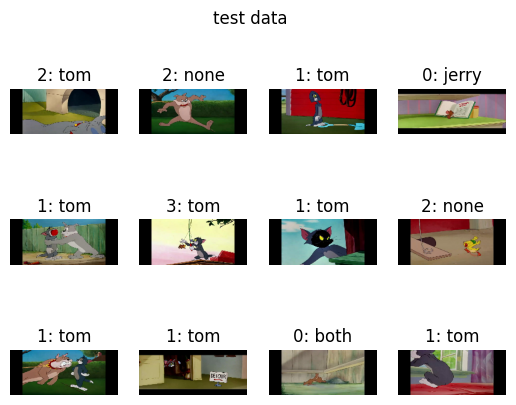

In [ ]:
fig, axes = plt.subplots(3, 4)

fig.suptitle("test data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    prompt[1] = Image.fromarray(image.numpy().astype("uint8"))
    response = model.generate_content(prompt)
    axes_ravel[i].set_title(f"{label}: {response.text}")

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "What is this? Please describe it in detail. it is an image of a cartoon called Tom And Jerry",
    Image.fromarray(images[0].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's a still image from the classic cartoon series *Tom and Jerry*.  Specifically, it shows Tom the cat lying on the ground, apparently injured or knocked out.

Here's a breakdown of the image:

* **Tom:**  Tom is depicted in a somewhat slumped position, suggesting he's been hurt. His eyes are closed or nearly closed, and his expression appears pained or dazed.  His fur is a greyish-blue, and some red markings are visible near his eye and mouth possibly indicating blood or injury. He is lying near a dark opening.

* **The Setting:** The background shows a simple, somewhat muted color palette. There's a section of what looks like a dirt or grassy area in front of an arched, stone-like structure or tunnel entrance. The structure has a greyish-tan hue. Part of a wall painted teal or light blue is visible in the far upper left corner. The overall environment is suggestive of an outdoor setting, perhaps near a drain or alleyway, typical of the show's backgrounds.

* **Overall Impression:*

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "What is this? Please describe it in detail.",
    Image.fromarray(images[-2].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's a still image from a Tom and Jerry cartoon.  Specifically, it appears to be a scene where Tom the cat is attempting to capture Jerry the mouse.

The detail shown depicts:

* **Setting:** The scene takes place outdoors, next to a wooden fence. The ground is grass.  A section of the fence is visible, showing a horizontal plank or beam running along the bottom.

* **Characters:** Two figures, presumably Tom and Jerry, are engaged in a struggle near the base of the fence.  The brown figures are blurry, but their shapes and positions strongly suggest a chase or fight. One is on top of, or pinning down, the other.

* **Action:**  The action implies violence or a struggle. The dust or dirt kicked up indicates movement and force.

* **Animation style:**  The image clearly shows the characteristic style of classic Tom and Jerry cartoons: simple shapes, limited detail, and a focus on exaggerated movement and expression (though facial features are not clearly visible in this still image).
